<a href="https://colab.research.google.com/github/weideng2019/Data-Analysis/blob/master/Dog_VS_Cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle
import random
import tensorflow as tf

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

#from __future__ import print_function
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
#from vis.utils import utils
from keras import activations
#from vis.visualization import visualize_activation, get_num_filters
#from vis.input_modifiers import Jitter

In [0]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

    def deprocess_image(x):
      # normalize tensor: center on 0., ensure std is 0.1
      x -= x.mean()
      x /= (x.std() + 1e-5)
      x *= 0.1

      # clip to [0, 1]
      x += 0.5
      x = np.clip(x, 0, 1)

      # convert to RGB array
      x *= 255
      x = np.clip(x, 0, 255).astype('uint8')
      return x
 
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

In [3]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"weideng621","key":"5d95834d8defa52d1fde91a70358ae78"}'}

In [4]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Apr 26 13:28 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [0]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c dogs-vs-cats

100% 270M/271M [00:05<00:00, 61.6MB/s]
100% 271M/271M [00:05<00:00, 53.3MB/s]
 99% 538M/543M [00:09<00:00, 70.9MB/s]
100% 543M/543M [00:09<00:00, 60.7MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 33.0MB/s]


In [9]:
from zipfile import ZipFile
filename='test1.zip'

with ZipFile(filename,"r") as zip:
        zip.extractall()
        print('unzipped')


unzipped


In [10]:
filename2='train.zip'

with ZipFile(filename2,"r") as zip:
        zip.extractall()
        print('unzipped')

unzipped


In [11]:
!ls

kaggle.json  sampleSubmission.csv  test1.zip  train.zip
sample_data  test1		   train


In [12]:
filenames=os.listdir('../content/train')
targets=[]
full_paths=[]
for filename in filenames:
    target = filename.split('.')[0]
    full_path=os.path.join('../content/train', filename)
    full_paths.append(full_path)
    targets.append(target)
    #if target == 'dog':
    #   targets.append(1)
    #else:
    #    targets.append(0)
df = pd.DataFrame({
    'image_path': full_paths,
    'category': targets
})
df.head()

image_path category
0  ../content/train/dog.1758.jpg      dog
1  ../content/train/cat.5277.jpg      cat
2  ../content/train/dog.8072.jpg      dog
3   ../content/train/dog.805.jpg      dog
4   ../content/train/cat.296.jpg      cat

In [14]:
df.shape

(25000, 2)

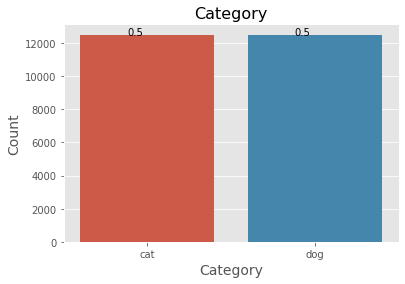

In [15]:
ax1 = sns.countplot(x='category', data=df, order = df.category.value_counts().index)
for p in ax1.patches:
    ax1.annotate('{0:.3}'.format(p.get_height()/len(df)), (p.get_x()+0.28, p.get_height()+0.8))
ax1.set_title("Category", fontsize='16')
ax1.set_ylabel('Count', fontsize='14')
ax1.set_xlabel('Category',fontsize='14')

plt.show()

In [0]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [17]:
train_df.head()

image_path category
0   ../content/train/cat.8980.jpg      cat
1  ../content/train/dog.10694.jpg      dog
2  ../content/train/cat.12419.jpg      cat
3   ../content/train/cat.9349.jpg      cat
4   ../content/train/cat.3600.jpg      cat

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
validate_datagen = ImageDataGenerator(rescale=1./255)

In [95]:
train_generator = train_datagen.flow_from_dataframe(
        train_df, 
        #"../content/train/", 
        x_col='image_path',
        y_col='category',
        target_size=(150,150),
        batch_size=100,
        class_mode='categorical')

Found 20000 validated image filenames belonging to 2 classes.


In [96]:
validation_generator = validate_datagen.flow_from_dataframe(
        validate_df, 
        x_col='image_path',
        y_col='category',
        target_size=(150,150),
        batch_size=100,
        class_mode='categorical')

Found 5000 validated image filenames belonging to 2 classes.


In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', 
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(2, activation='softmax', name='output'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# To prevent over fitting, stop the learning after 10 epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=10)

# Reduce the learning rate when then accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [107]:
history = model.fit_generator(train_generator, 
                              epochs=50,
                              steps_per_epoch=train_df.shape[0]//100, 
                              validation_data=validation_generator, 
                              validation_steps=validate_df.shape[0]//100,
                              callbacks=callbacks,
                              verbose=1)

Epoch 1/50
200/200 [==============================] - 73s 365ms/step - loss: 0.5435 - accuracy: 0.7262 - val_loss: 0.4190 - val_accuracy: 0.7834
Epoch 2/50
200/200 [==============================] - 71s 355ms/step - loss: 0.4547 - accuracy: 0.7847 - val_loss: 0.4382 - val_accuracy: 0.8082
Epoch 3/50
200/200 [==============================] - 70s 349ms/step - loss: 0.3987 - accuracy: 0.8194 - val_loss: 0.4622 - val_accuracy: 0.8328
Epoch 4/50
200/200 [==============================] - 70s 350ms/step - loss: 0.3361 - accuracy: 0.8522 - val_loss: 0.3795 - val_accuracy: 0.8726
Epoch 5/50
200/200 [==============================] - 69s 343ms/step - loss: 0.2916 - accuracy: 0.8776 - val_loss: 0.3114 - val_accuracy: 0.8738
Epoch 6/50
200/200 [==============================] - 69s 346ms/step - loss: 0.2653 - accuracy: 0.8892 - val_loss: 0.4133 - val_accuracy: 0.8784
Epoch 7/50
200/200 [==============================] - 70s 348ms/step - loss: 0.2297 - accuracy: 0.9025 - val_loss: 0.2773 - val_ac

In [0]:
model.save('../content/model.h5')
save_history(history, 'history.bin')

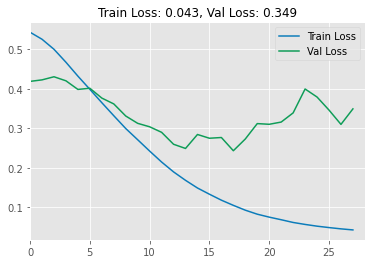

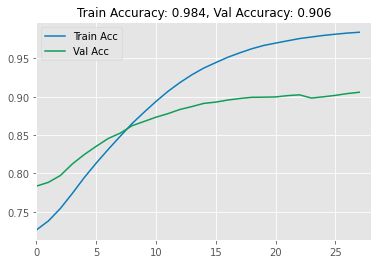

In [109]:
history = load_history('history.bin')
plot_compare(history)

In [0]:
# Data augmentation on train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validate_datagen = ImageDataGenerator(rescale=1./255)

In [112]:
train_generator = train_datagen.flow_from_dataframe(
        train_df, 
        #"../content/train/", 
        x_col='image_path',
        y_col='category',
        target_size=(150,150),
        batch_size=100,
        class_mode='categorical')


validation_generator = validate_datagen.flow_from_dataframe(
        validate_df, 
        x_col='image_path',
        y_col='category',
        target_size=(150,150),
        batch_size=100,
        class_mode='categorical')


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [0]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', 
                 input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(Dense(2, activation='softmax', name='output'))

model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [114]:
history_aug = model_aug.fit_generator(train_generator, 
                              epochs=50,
                              steps_per_epoch=train_df.shape[0]//100, 
                              validation_data=validation_generator, 
                              validation_steps=validate_df.shape[0]//100,
                              callbacks=callbacks,
                              verbose=1)

Epoch 1/50
200/200 [==============================] - 159s 797ms/step - loss: 0.6681 - accuracy: 0.5746 - val_loss: 0.5726 - val_accuracy: 0.6642
Epoch 2/50
200/200 [==============================] - 152s 758ms/step - loss: 0.6079 - accuracy: 0.6618 - val_loss: 0.5270 - val_accuracy: 0.7402
Epoch 3/50
200/200 [==============================] - 151s 757ms/step - loss: 0.5788 - accuracy: 0.6926 - val_loss: 0.5753 - val_accuracy: 0.7308
Epoch 4/50
200/200 [==============================] - 150s 749ms/step - loss: 0.5387 - accuracy: 0.7241 - val_loss: 0.4845 - val_accuracy: 0.7936
Epoch 5/50
200/200 [==============================] - 150s 750ms/step - loss: 0.5133 - accuracy: 0.7459 - val_loss: 0.4198 - val_accuracy: 0.7718
Epoch 6/50
200/200 [==============================] - 150s 748ms/step - loss: 0.4733 - accuracy: 0.7732 - val_loss: 0.3932 - val_accuracy: 0.8188
Epoch 7/50
200/200 [==============================] - 150s 748ms/step - loss: 0.4485 - accuracy: 0.7861 - val_loss: 0.4495 -

In [0]:
model_aug.save('../content/model_aug.h5')
save_history(history_aug, 'history_aug.bin')

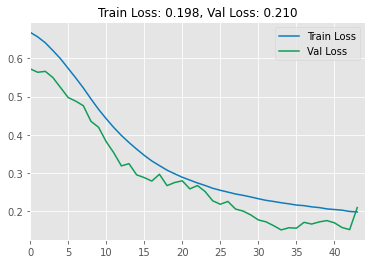

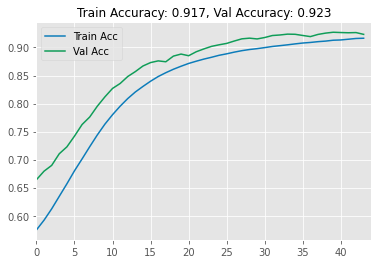

In [116]:
history_aug = load_history('history_aug.bin')
plot_compare(history_aug)

In [24]:
filenames=os.listdir('../content/test1')
full_paths=[]
for filename in filenames:
    full_path=os.path.join('../content/test1', filename)
    full_paths.append(full_path)
    #if category == 'dog':
     #   targets.append(1)
    #else:
    #    targets.append(0)
test = pd.DataFrame({
    'image_path': full_paths
})
test.head()

image_path
0   ../content/test1/5449.jpg
1   ../content/test1/6502.jpg
2   ../content/test1/4950.jpg
3     ../content/test1/88.jpg
4  ../content/test1/12476.jpg

In [0]:
nb_samples=test.shape[0]

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
        test, 
        x_col='image_path',
        y_col=None,
        target_size=(150,150),
        batch_size=100,
        class_mode=None)

Found 12500 validated image filenames.


In [0]:
predict = model_aug.predict_generator(test_generator, steps=np.ceil(nb_samples/100))

In [121]:
predict[0:18]

array([[9.9631917e-01, 3.6808148e-03],
       [9.0672374e-12, 1.0000000e+00],
       [6.3277767e-03, 9.9367225e-01],
       [3.6981464e-06, 9.9999630e-01],
       [5.9736526e-01, 4.0263477e-01],
       [1.3470731e-04, 9.9986529e-01],
       [9.9802881e-01, 1.9711591e-03],
       [8.2431024e-01, 1.7568980e-01],
       [8.7124479e-01, 1.2875521e-01],
       [1.5294558e-01, 8.4705442e-01],
       [6.6706246e-01, 3.3293751e-01],
       [9.9495053e-01, 5.0494224e-03],
       [1.6713468e-05, 9.9998331e-01],
       [9.9999440e-01, 5.6447134e-06],
       [9.7274199e-02, 9.0272576e-01],
       [1.8637702e-07, 9.9999976e-01],
       [5.6521096e-03, 9.9434787e-01],
       [9.9999797e-01, 1.9779911e-06]], dtype=float32)

In [0]:
#predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test['category'] = np.where(predict > threshold, 'dog','cat')

In [0]:
test['category'] = np.argmax(predict, axis=-1) #if multi-class or class_mode= catrgories

In [0]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test['category'] = test['category'].replace(label_map)

In [124]:
test.head(18)

image_path category
0    ../content/test1/5449.jpg      cat
1    ../content/test1/6502.jpg      dog
2    ../content/test1/4950.jpg      dog
3      ../content/test1/88.jpg      dog
4   ../content/test1/12476.jpg      cat
5    ../content/test1/5606.jpg      dog
6   ../content/test1/10493.jpg      cat
7      ../content/test1/57.jpg      cat
8    ../content/test1/6600.jpg      cat
9    ../content/test1/5849.jpg      dog
10   ../content/test1/7189.jpg      cat
11   ../content/test1/8954.jpg      cat
12    ../content/test1/414.jpg      dog
13   ../content/test1/6774.jpg      cat
14  ../content/test1/11511.jpg      dog
15  ../content/test1/11039.jpg      dog
16   ../content/test1/7225.jpg      dog
17  ../content/test1/11420.jpg      cat

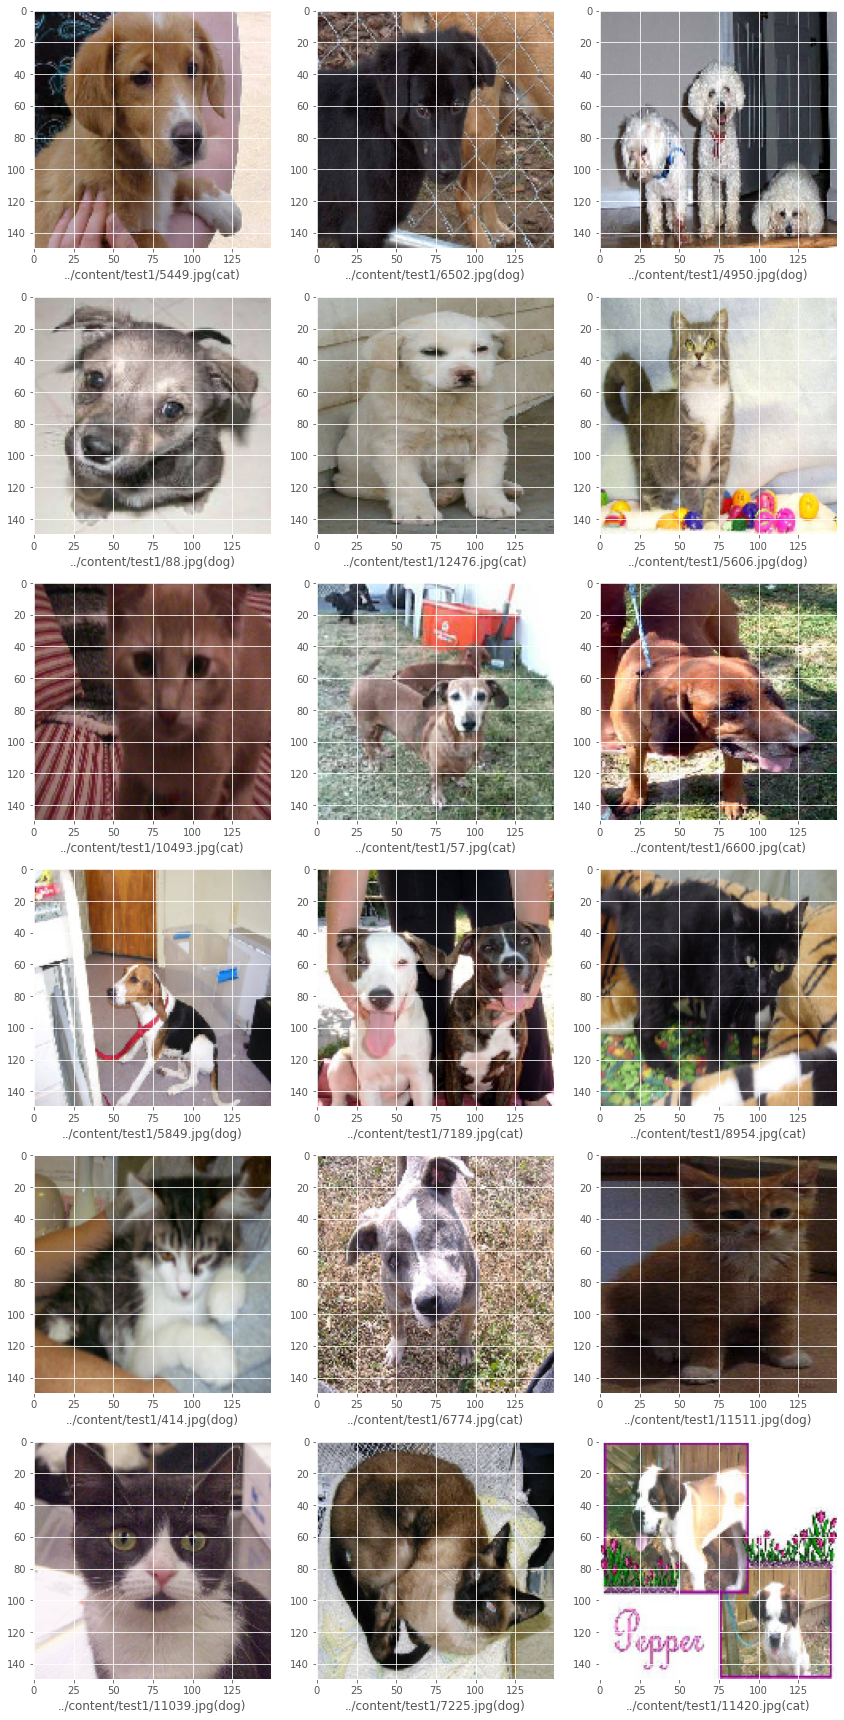

In [125]:
sample_test = test.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['image_path']
    category = row['category']
    img = load_img(filename, target_size=(150,150))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [15]:
from sklearn.utils import shuffle
df_shuffled = shuffle(df)

df_shuffled.head()

image_path category
22792   ../content/train/cat.2221.jpg      cat
2150    ../content/train/dog.2745.jpg      dog
19373   ../content/train/cat.4929.jpg      cat
8273    ../content/train/dog.9595.jpg      dog
4519   ../content/train/dog.11423.jpg      dog

In [0]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df_shuffled, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [0]:
# Data augmentation on train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validate_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_dataframe(
        train_df, 
        #"../content/train/", 
        x_col='image_path',
        y_col='category',
        target_size=(150,150),
        batch_size=100,
        class_mode='categorical')


validation_generator = validate_datagen.flow_from_dataframe(
        validate_df, 
        x_col='image_path',
        y_col='category',
        target_size=(150,150),
        batch_size=100,
        class_mode='categorical')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [0]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', 
                 input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(Dense(2, activation='softmax', name='output'))

model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history_aug = model_aug.fit_generator(train_generator, 
                              epochs=50,
                              steps_per_epoch=train_df.shape[0]//100, 
                              validation_data=validation_generator, 
                              validation_steps=validate_df.shape[0]//100,
                              callbacks=callbacks,
                              verbose=1)

Epoch 1/50
200/200 [==============================] - 181s 904ms/step - loss: 0.6885 - accuracy: 0.5402 - val_loss: 0.6816 - val_accuracy: 0.5670
Epoch 2/50
200/200 [==============================] - 168s 839ms/step - loss: 0.6637 - accuracy: 0.5941 - val_loss: 0.5827 - val_accuracy: 0.6620
Epoch 3/50
200/200 [==============================] - 167s 836ms/step - loss: 0.6071 - accuracy: 0.6665 - val_loss: 0.6181 - val_accuracy: 0.6130
Epoch 4/50
200/200 [==============================] - 169s 847ms/step - loss: 0.5674 - accuracy: 0.7020 - val_loss: 0.5269 - val_accuracy: 0.7664
Epoch 5/50
200/200 [==============================] - 168s 840ms/step - loss: 0.5313 - accuracy: 0.7342 - val_loss: 0.4461 - val_accuracy: 0.7864
Epoch 6/50
200/200 [==============================] - 167s 837ms/step - loss: 0.5133 - accuracy: 0.7465 - val_loss: 0.4138 - val_accuracy: 0.8190
Epoch 7/50
200/200 [==============================] - 166s 829ms/step - loss: 0.4792 - accuracy: 0.7691 - val_loss: 0.3451 -

In [0]:
model_aug.save('../content/model_aug.h5')
save_history(history_aug, 'history_aug.bin')

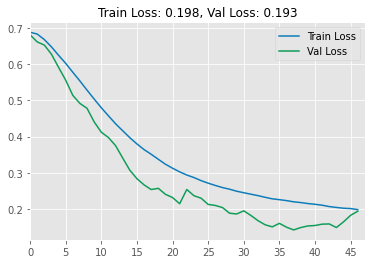

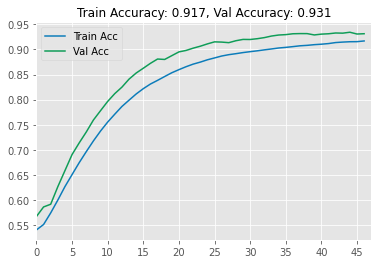

In [23]:
history_aug = load_history('history_aug.bin')
plot_compare(history_aug)

In [0]:
predict_new = model_aug.predict_generator(test_generator, steps=np.ceil(nb_samples/100))

In [0]:
test['category'] = np.argmax(predict_new, axis=-1) #if multi-class or class_mode= catrgories

In [0]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test['category'] = test['category'].replace(label_map)

In [32]:
test.head(18)

image_path category
0    ../content/test1/5449.jpg      dog
1    ../content/test1/6502.jpg      cat
2    ../content/test1/4950.jpg      dog
3      ../content/test1/88.jpg      dog
4   ../content/test1/12476.jpg      cat
5    ../content/test1/5606.jpg      dog
6   ../content/test1/10493.jpg      cat
7      ../content/test1/57.jpg      dog
8    ../content/test1/6600.jpg      cat
9    ../content/test1/5849.jpg      cat
10   ../content/test1/7189.jpg      cat
11   ../content/test1/8954.jpg      cat
12    ../content/test1/414.jpg      cat
13   ../content/test1/6774.jpg      cat
14  ../content/test1/11511.jpg      cat
15  ../content/test1/11039.jpg      dog
16   ../content/test1/7225.jpg      dog
17  ../content/test1/11420.jpg      dog

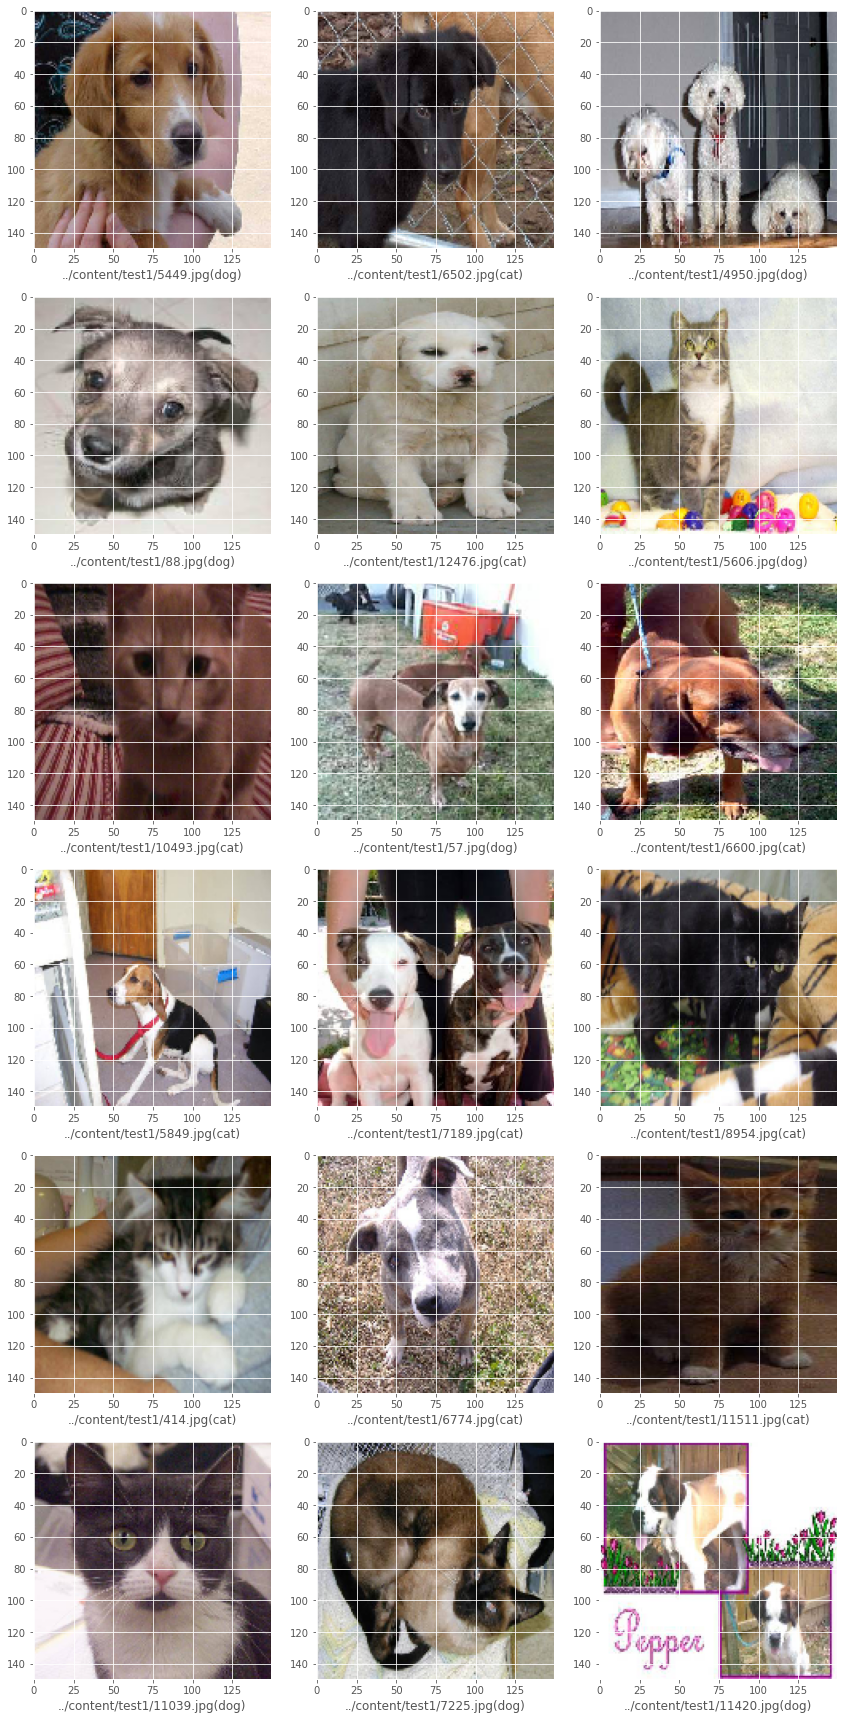

In [33]:
sample_test = test.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['image_path']
    category = row['category']
    img = load_img(filename, target_size=(150,150))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [35]:
# Data augmentation on train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

validate_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
        train_df, 
        #"../content/train/", 
        x_col='image_path',
        y_col='category',
        target_size=(150,150),
        batch_size=100,
        class_mode='categorical')


validation_generator = validate_datagen.flow_from_dataframe(
        validate_df, 
        x_col='image_path',
        y_col='category',
        target_size=(150,150),
        batch_size=100,
        class_mode='categorical')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [0]:
model_aug.add(BatchNormalization())

model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1', 
                 input_shape=(150, 150, 3)))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(BatchNormalization())
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(BatchNormalization())
model_aug.add(Dense(2, activation='softmax', name='output'))

model_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
history_aug = model_aug.fit_generator(train_generator, 
                              epochs=50,
                              steps_per_epoch=train_df.shape[0]//100, 
                              validation_data=validation_generator, 
                              validation_steps=validate_df.shape[0]//100,
                              callbacks=callbacks,
                              verbose=1)

Epoch 1/50
200/200 [==============================] - 182s 910ms/step - loss: 0.6192 - accuracy: 0.6869 - val_loss: 1.5524 - val_accuracy: 0.5046
Epoch 2/50
200/200 [==============================] - 171s 857ms/step - loss: 0.4826 - accuracy: 0.7671 - val_loss: 1.1099 - val_accuracy: 0.5288
Epoch 3/50
200/200 [==============================] - 170s 850ms/step - loss: 0.4319 - accuracy: 0.7976 - val_loss: 0.4318 - val_accuracy: 0.8044
Epoch 4/50
200/200 [==============================] - 170s 848ms/step - loss: 0.3803 - accuracy: 0.8257 - val_loss: 0.3675 - val_accuracy: 0.8494
Epoch 5/50
200/200 [==============================] - 169s 843ms/step - loss: 0.3377 - accuracy: 0.8519 - val_loss: 0.8662 - val_accuracy: 0.6582
Epoch 6/50
200/200 [==============================] - 168s 841ms/step - loss: 0.2862 - accuracy: 0.8727 - val_loss: 0.2666 - val_accuracy: 0.8704
Epoch 7/50
200/200 [==============================] - 168s 838ms/step - loss: 0.2636 - accuracy: 0.8878 - val_loss: 0.3128 -

In [0]:
model_aug.save('../content/model_aug.h5')
save_history(history_aug, 'history_aug.bin')

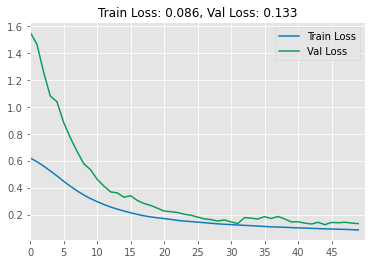

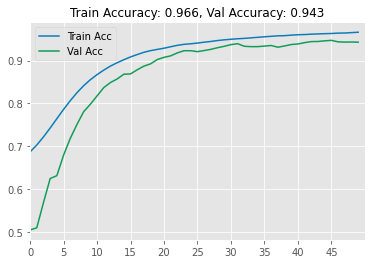

In [41]:
history_aug = load_history('history_aug.bin')
plot_compare(history_aug)

In [42]:
predict_new = model_aug.predict_generator(test_generator, steps=np.ceil(nb_samples/100))

test['category'] = np.argmax(predict_new, axis=-1) #if multi-class or class_mode= catrgories

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test['category'] = test['category'].replace(label_map)

test.head(18)


image_path category
0    ../content/test1/5449.jpg      dog
1    ../content/test1/6502.jpg      cat
2    ../content/test1/4950.jpg      cat
3      ../content/test1/88.jpg      dog
4   ../content/test1/12476.jpg      cat
5    ../content/test1/5606.jpg      dog
6   ../content/test1/10493.jpg      cat
7      ../content/test1/57.jpg      dog
8    ../content/test1/6600.jpg      cat
9    ../content/test1/5849.jpg      cat
10   ../content/test1/7189.jpg      cat
11   ../content/test1/8954.jpg      cat
12    ../content/test1/414.jpg      cat
13   ../content/test1/6774.jpg      cat
14  ../content/test1/11511.jpg      cat
15  ../content/test1/11039.jpg      cat
16   ../content/test1/7225.jpg      dog
17  ../content/test1/11420.jpg      dog